## LIBRARIES

In [18]:
import math
import pygame #May need to run: pip install pygame
import random
import numpy as np
import matplotlib.pyplot as plt

## FUNCTIONS

In [19]:
def wrap_angle_rad(angle):
    """Wrap angle to [0, 2π)"""
    return angle % (2 * math.pi)

In [20]:
def pose_estimation(delta_D,delta_theta,previous_pose):
    '''Dynamics fucntion'''
    # TO DO: add the uncertainty 
    
    # Movement noise following a Normal distribution
    mean = np.zeros(3) #zero mean
    cov = np.eye(3)    #identity matrix 
    epsilon = np.random.multivariate_normal(mean, cov) #MAYBE the scale of this estimation is too large for the angle

    # Prediction of the  new pose
    new_pose = np.zeros(3,dtype=float)

    # Orientation
    theta_t = previous_pose[2]
    theta_t_1 = theta_t + delta_theta #+ epsilon[2]
    new_pose[2] = theta_t_1

    # X coordinate 
    x_t = previous_pose[0]
    x_t_1 = x_t + delta_D*np.cos(theta_t) #+ epsilon[0]
    new_pose[0] = x_t_1 

    # Y cordinate
    y_t = previous_pose[1]
    y_t_1 = y_t + delta_D*np.sin(theta_t) #+ epsilon[1]
    new_pose[1] = y_t_1 

    return new_pose

In [21]:
def observation_prediction(pose):
    '''Obserbavility function''' 

    #TO DO: p_x and p_y from the real map, identify the landmark and delete the following line when it's done
    p_x = 3.0 #x coordenate mean of landmark i in a concrete particle 
    p_y = 2.0 #y coordenate mean of landmark i in a concrete particle

    # Measurement noise following a Normal distribution
    mean = np.zeros(2) #zero mean
    cov = np.eye(2)    #identity matrix 
    epsilon = np.random.multivariate_normal(mean, cov)
    
    z_hat = np.zeros(2,dtype = float)

    # Range
    r_hat = math.sqrt(((p_x - pose[0])**2) + ((p_y - pose[1])**2)) #+ epsilon[0]
    z_hat[0] = r_hat
    
    # Angle
    phi_hat = math.atan((p_y - pose[1])/(p_x - pose[0])) - pose[2] #+ epsilon[1]
    z_hat[1] = phi_hat

    return z_hat

In [22]:
def compute_weight(observation, pose, variance): 

    # TO DO: discover the variance of the sensor: are they const or dynamic?
    '''
    Input:
     - real measurements taken from the sensor
     - the variance of the sensor: both in distance ([0]) and angle ([1])
     - the estimated pose

    Output:
     - weght = probability an observaion given the robot's pose
    '''

    # Predictions based on the estimated position of the robot 
    z_predicted = observation_prediction(pose)
    r_hat = z_predicted[0] #distance between sensor and landmark 
    phi_hat = z_predicted[1] #angle between sensor and landmark 

    # Real position based on the sensor data
    r = observation[0]
    phi = observation[1]

    # Compute the probabilities for each variable (Gaussian distribution) 
    p_zr_given_xi = (1/math.sqrt(2*math.pi*variance[0]))*math.exp(-(r-r_hat)/2*variance[0]) 
    p_zphi_given_xi = (1/math.sqrt(2*math.pi*variance[1]))*math.exp(-(phi-phi_hat)/2*variance[1]) 

    # Compute joined probabilities of incorrelated variables
    return p_zr_given_xi*p_zphi_given_xi

In [23]:
def update_particles(particles, new_pose):
    '''Add the last poses of each particle to its particle'''
    return np.hstack((particles, new_pose))

In [24]:
def resample(particles,weights,n_particles):
    '''Resample the particles with replazament'''
    
    # Weights normalization
    weights = weights/np.sum(weights)

    # Resampling 
    N = n_particles
    indexes = np.random.choice(N, size=N, p=weights) 
    particles = particles[indexes, :, :]
    return particles

In [ ]:
def compute_Jacobian(delta_D, previous_angle):
    Jacobian = np.zeros(3,3)
    Jacobian[0,0] = 1
    Jacobian[1,1] = 1
    Jacobian[2,2] = 1
    Jacobian[0,2] = -delta_D*math.sin(previous_angle)
    Jacobian[1,2] = delta_D*math.cos(previous_angle)

    return Jacobian.copy()


In [ ]:
def compute_uncertainty(previous_un, delta_D, previous_angle):

    

    return 


: 

## CLASSES

In [26]:
class Envo:
    def __init__(self,dimensions):
        self.black = (0,0,0)
        self.white = (255,255,255)
        self.green = (0,255,0)
        self.blue = (0,0,255)
        self.red = (255,0,0)
        self.yellow = (255,255,0)

        self.length = dimensions[0]
        self.width = dimensions[1]

        pygame.display.set_caption("Differential Drive Robot")
        self.win = pygame.display.set_mode((self.length,self.width))

        self.font = pygame.font.Font('freesansbold.ttf',35)
        self.text = self.font.render('default',True,self.white,self.black)
        self.textrect = self.text.get_rect()
        self.textrect.center=(dimensions[1]-175, dimensions[0]-500)
        self.traj_set=[]

    def write (self, velL, velR, theta):
        txt = f"Vel L = {velL/3779.52:.3f} Vel R ={velR/3779.52:.3f} theta = {int(math.degrees(wrap_angle_rad(theta)))}"
        self.text=self.font.render(txt,True,self.white,self.black)
        self.win.blit(self.text,self.textrect)

    def trajectory(self,pos):
        for i in range(0,len(self.traj_set)-1):
            pygame.draw.line(self.win,self.red,(self.traj_set[i][0],self.traj_set[i][1]),(self.traj_set[i+1][0],self.traj_set[i+1][1]))
        if self.traj_set.__sizeof__()>300000:
            self.traj_set.pop(0)
        self.traj_set.append(pos)

In [27]:
class Robot:
    def __init__(self, startpoint, robotimg, width):
        self.met2pix = 3779.52
        self.wd = width
        self.x = startpoint[0]
        self.y = startpoint[1]
        self.theta = 0
        self.velL = 0.01 * self.met2pix
        self.velR = 0.01 * self.met2pix
        self.max = 0.05 * self.met2pix
        self.min = 0.002 * self.met2pix

        self.imge = pygame.image.load(robotimg).convert_alpha()
        self.rotate = self.imge
        self.rect = self.rotate.get_rect(center=(self.x, self.y))

    def draw(self,win):
        win.blit(self.rotate,self.rect)

    def update_velocities(self, keys):
        increment = 0.0001 * self.met2pix

        if keys[pygame.K_4]:  # Increase left
            self.velL = min(self.velL + increment, self.max)
        if keys[pygame.K_1]:  # Decrease left
            self.velL = max(self.velL - increment, self.min)
        if keys[pygame.K_6]:  # Increase right
            self.velR = min(self.velR + increment, self.max)
        if keys[pygame.K_3]:  # Decrease right
            self.velR = max(self.velR - increment, self.min)
        if keys[pygame.K_5]:  # Increase both
            self.velL = min(self.velL + increment, self.max)
            self.velR = min(self.velR + increment, self.max)
        if keys[pygame.K_2]:  # Decrease both
            self.velL = max(self.velL - increment, self.min)
            self.velR = max(self.velR - increment, self.min)
        if keys[pygame.K_SPACE]:  # Equalize both velocities
            avg = (self.velL + self.velR) / 2
            self.velL = self.velR = avg

    def update_kinematics(self):
        self.x += ((self.velL + self.velR) / 2) * math.cos(self.theta) * dt
        self.y -= ((self.velL + self.velR) / 2) * math.sin(self.theta) * dt
        self.theta += (self.velR - self.velL) / self.wd * dt
    
        self.rotate = pygame.transform.rotozoom(self.imge, math.degrees(self.theta), 1)
        self.rect = self.rotate.get_rect(center=(self.x, self.y))
        

In [28]:
class CarSensor:
    def __init__(self, car_width, sensor_width, sensor_reach, color=(0, 255, 0)):
        self.car_width = car_width
        self.sensor_width = sensor_width
        self.sensor_reach = sensor_reach
        self.color = color

    def compute_trapezoid(self, x, y, theta):
        # Half widths
        half_car = self.car_width / 2
        half_sensor = self.sensor_width / 2

        # Sensor front points
        front_left = (
            x + self.sensor_reach * math.cos(theta) - half_sensor * math.sin(theta),
            y - self.sensor_reach * math.sin(theta) - half_sensor * math.cos(theta),
        )
        front_right = (
            x + self.sensor_reach * math.cos(theta) + half_sensor * math.sin(theta),
            y - self.sensor_reach * math.sin(theta) + half_sensor * math.cos(theta),
        )

        # Sensor rear points (near robot front)
        rear_left = (
            x - half_car * math.sin(theta),
            y - half_car * math.cos(theta),
        )
        rear_right = (
            x + half_car * math.sin(theta),
            y + half_car * math.cos(theta),
        )

        # Return points in order (rear_left, front_left, front_right, rear_right)
        return [rear_left, front_left, front_right, rear_right]

    def point_in_polygon(self, point, polygon):
        x, y = point
        inside = False
        n = len(polygon)
        for i in range(n):
            x1, y1 = polygon[i]
            x2, y2 = polygon[(i + 1) % n]
            if ((y1 > y) != (y2 > y)) and \
                (x < (x2 - x1) * (y - y1) / (y2 - y1 + 1e-9) + x1):
                inside = not inside
        return inside

    def filter_landmarks(self, landmarks_positions, robot_pos, robot_theta):
        polygon = self.compute_trapezoid(robot_pos[0], robot_pos[1], robot_theta)
        visible = []
        for pos in landmarks_positions:
            if self.point_in_polygon(pos, polygon):
                visible.append(pos)
        return visible

    def draw(self, win, robot_pos, robot_theta):
        polygon = self.compute_trapezoid(robot_pos[0], robot_pos[1], robot_theta)
        pygame.draw.polygon(
            win, self.color,
            [(int(p[0]), int(p[1])) for p in polygon], 2
        )

In [29]:
class Landmarks:
    def __init__(self, num_landmarks, window_size, radius=8, color=(0, 0, 255), min_dist=100):
        """
        num_landmarks: how many landmarks to generate
        window_size: tuple (width, height) for placing landmarks inside screen
        radius: radius of each landmark circle
        color: RGB color tuple for landmarks
        min_dist: minimum allowed distance between landmarks
        """
        self.num = num_landmarks
        self.width, self.height = window_size
        self.radius = radius
        self.color = color
        self.min_dist = min_dist
        
        self.positions = []
        self._generate_positions()
    
    def _generate_positions(self):

        attempts_limit = 1000  # max tries to place a landmark
        for _ in range(self.num):
            attempts = 0
            while attempts < attempts_limit:
                x = random.randint(self.radius, self.width - self.radius)
                y = random.randint(self.radius, self.height - self.radius)
                pos = (x, y)
                
                if self._is_far_enough(pos):
                    self.positions.append(pos)
                    break
                attempts += 1
            else:
                print(f"Warning: Could only place {_} landmarks out of {self.num} due to spacing constraints.")
                break

    def _is_far_enough(self, pos):
        for p in self.positions:
            dist = math.hypot(pos[0] - p[0], pos[1] - p[1])
            if dist < self.min_dist:
                return False
        return True
    
    def draw(self, win):
        for pos in self.positions:
            pygame.draw.circle(win, self.color, pos, self.radius)
    
    def get_positions(self):
        return self.positions

In [30]:
class Particle:
    def __init__(self, num_landmarks, path, landmark_mean, landmark_covariance):
        
        self.num = num_landmarks
        


## MAIN

In [31]:
#DELETE this later: these imputs must be taken from the sensor
delta_D = 0.2
observation = np.ones(2, dtype=float) #this must be read from the sensor:
                                       #the first value must be the distance between the sensor and the landmark
                                       #the second value must be the angle  
variance = np.ones(2, dtype=float) #this is the varince in the sensor: first regarding distance and second angle (EKF unit)

0
0.009999999999999998


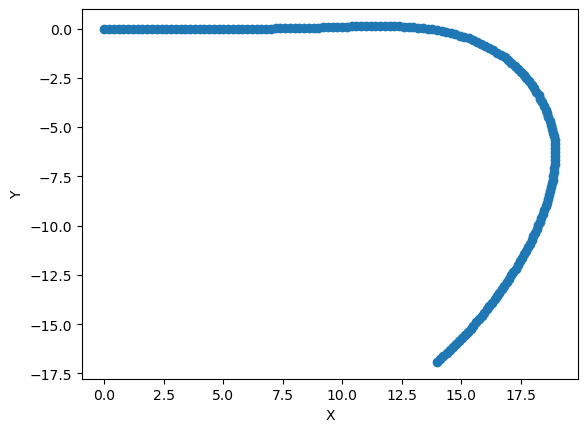

In [ ]:
pygame.init()

dim = (1200, 800)
env = Envo(dim)
start = (400, 200)
rob = Robot(start, "Robot.png", 0.01 * 3779.52)
landmarks = Landmarks(num_landmarks=10, window_size=(dim[0], dim[1]))

# The following three lines are probisional 
# Inizialization
n_particles = 100
particles = np.zeros((n_particles, 1, 3), dtype=float) 
'''
First column is the particle
Second column is the time instant
Third column are the three components of the state (x,y,theta)
All of them start in the pose (0,0,0)
'''
uncertainties  = np.zeros((n_particles,1,3,3),dtype = float)
'''
First column is the particle
Second column is the time instant
Then, each cell represents the uncertanty matrix of a particle in a concrete instant of time
As the initial pose is (0,0,0), our uncertity there will be 0. 
'''

weights = np.ones(n_particles, dtype=float)/n_particles
most_probable = 0
previous_theta = 0
#previous_velL = 0.01 * rob.met2pix
#previous_velR = 0.01 * rob.met2pix

sensor = CarSensor(
    car_width=rob.wd,  # your robot width
    sensor_width=200,  # sensor trapezoid width in pixels, tweak as needed
    sensor_reach=150,  # sensor reach in pixels, tweak as needed
    color=(0, 255, 0)  # green trapezoid
)

clock = pygame.time.Clock()
highlighted = set()

dt = 0
prevtime = pygame.time.get_ticks()

run= True

time_instant = 1 
while run:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            run = False

    keys = pygame.key.get_pressed()  # get all keys pressed right now
    rob.update_velocities(keys)       # update velocities continuously if keys held
    rob.update_kinematics()           # update position and angle based on velocities

    dt = clock.tick(60) / 1000.0
    prevtime = pygame.time.get_ticks()

    env.win.fill(env.white)           # Clear screen first
    landmarks.draw(env.win)           # Draw landmarks
    rob.draw(env.win)
    env.trajectory((rob.x, rob.y))
    env.write(int(rob.velL), int(rob.velR), rob.theta)
    pygame.display.update()           # Update screen last
    
    sensor.draw(env.win, (rob.x, rob.y), rob.theta)

    #Landmark Detection
    visible_landmarks = sensor.filter_landmarks(landmarks.get_positions(), (rob.x, rob.y), rob.theta)

    # For example, highlight visible landmarks in red
    for vpos in visible_landmarks:
        pygame.draw.circle(env.win, env.red, (int(vpos[0]), int(vpos[1])), landmarks.radius + 3, 2)

    #Path estimation
    new_pose = np.zeros((n_particles, 1, 3), dtype=float) 

    for k in range(n_particles): #For each particle

        #TO DO: Delta D

        # Delta theta 
        delta_theta = rob.theta - previous_theta #CHECK if it is in rad!
        # Pose estimation
        new_pose[k,0,:] = pose_estimation(delta_D,delta_theta,particles[k,time_instant-1,:])

        # Weight computing
        # TO DO: add the obsevation taken from the sensor 
        weights[k] = compute_weight(observation,new_pose[k,0,:],variance)


    # Particle updating
    particles = update_particles(particles, new_pose)
   
    # Resampling
    particles = resample(particles,weights,n_particles)
    
    most_probable = np.argmax(weights)

    time_instant += 1
    previous_theta = rob.theta

    pygame.display.update()         

pygame.quit()


plt.scatter(particles[most_probable,:,0],particles[most_probable,:,1])
plt.xlabel('X')
plt.ylabel('Y')
print(most_probable)
print(weights[most_probable]/np.sum(weights))

In [33]:
particles

array([[[  0.        ,   0.        ,   0.        ],
        [  0.2       ,   0.        ,   0.        ],
        [  0.4       ,   0.        ,   0.        ],
        ...,
        [ 14.25382568, -16.62464064,  -2.31502   ],
        [ 14.1183455 , -16.77176344,  -2.32172   ],
        [ 13.98188263, -16.91797523,  -2.33362   ]],

       [[  0.        ,   0.        ,   0.        ],
        [  0.2       ,   0.        ,   0.        ],
        [  0.4       ,   0.        ,   0.        ],
        ...,
        [ 14.25382568, -16.62464064,  -2.31502   ],
        [ 14.1183455 , -16.77176344,  -2.32172   ],
        [ 13.98188263, -16.91797523,  -2.33362   ]],

       [[  0.        ,   0.        ,   0.        ],
        [  0.2       ,   0.        ,   0.        ],
        [  0.4       ,   0.        ,   0.        ],
        ...,
        [ 14.25382568, -16.62464064,  -2.31502   ],
        [ 14.1183455 , -16.77176344,  -2.32172   ],
        [ 13.98188263, -16.91797523,  -2.33362   ]],

       ...,

      

In [34]:
particles[0]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.00000000e-01,  0.00000000e+00,  0.00000000e+00],
       [ 4.00000000e-01,  0.00000000e+00,  0.00000000e+00],
       [ 6.00000000e-01,  0.00000000e+00,  0.00000000e+00],
       [ 8.00000000e-01,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.20000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.40000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.60000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.80000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.20000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.40000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.60000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.80000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.20000000e+00,  0.00000000e+00